# Bloc import

In [2]:
import csv
import numpy as np
from statistics import mean
from collections import Counter, namedtuple
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Bloc fonctions

In [3]:
def takethecol(data,namecol):
    '''
    Prend en argument data (les données) et namecol (chaîne de caractères) le nom de la colonne à prendre
    Retourne une liste avec la colonne correspondante
    '''
    i0 = data[0].index(namecol)
    n = len(data)-1
    li = [data[j][i0] for j in range(1,n)]
    return li

def anneePlantation(data):
    '''
    Prend en argument data : les données (liste de listes, avec chaque ligne=1 arbre, sauf la 1ère)
    Retourne une liste avec toutes les années de plantation
    '''
    li=takethecol(data,'ANNEEDEPLANTATION')
    liInt=[int(var) for var in li if(var!='')]
    return liInt

def minmaxAnnee(data):
    '''
    Prend en argument data : les données
    Retourne la plus petite année de plantation et la plus récente'''
    liAnnee=anneePlantation(data)
    
    minAnnee=min(liAnnee)
    maxAnnee=max(liAnnee)
    
    return minAnnee,maxAnnee

def anneeNombrePlantation(data):
    '''
    Prend en argument data : les données
    Retourne un dictionnaire qui associe l'année de plantation et le nombre d'arbres plantés correspondant
    '''
    liAnnee=anneePlantation(data)
    
    minAnnee,maxAnnee=minmaxAnnee(data)
    
    arbresAnnee={}
    for i in range(minAnnee,maxAnnee+1):
        arbresAnnee[i]=liAnnee.count(i)
        
    return arbresAnnee

def convert2tuples(dic):
    '''
    Prend en argument un dictionnaire : dic
    Retourne une liste de tuples qui associe la key et l'élément correspondant
    '''
    liTuples=[]
    for key in dic:
        liTuples.append((str(key),dic[key]))
    return liTuples

def filtreVille(data, ville):
    '''
    Prend en argument data : les données
    Filtre en ne gardant que la ville choisie : ville (chaîne de caractères)
    Retourne les données filtrées
    '''
    dataFiltered = [data[i] for i in range(len(data)) if(data[i][-2]==ville or i==0)]
    return dataFiltered

def dictMairePlantation(data, dicmaires):
    '''
    Prend en argument : 
    - les données (data) 
    - un dictionnaire des maires (dicmaires, sous la forme : maire : (an_debut,an_fin))
    Retourne un dictionnaire sous la forme : maire : nombre d'arbres plantés '''
    
    dicmairesArbres = {}
    minAnnee,maxAnnee=minmaxAnnee(data)
    
    arbresAnnee = anneeNombrePlantation(data)
    
    for key in dicmaires:
        dicmairesArbres[key] = sum([arbresAnnee[int(y)] for y in range(dicmaires[key][0],dicmaires[key][1]) if y>=minAnnee and y<=maxAnnee])
    return dicmairesArbres

def dictMairePlantationNorm(data, dicmaires):
    '''
    Prend en argument : 
    - les données (data) 
    - un dictionnaire des maires (dicmaires, sous la forme : maire : (an_debut,an_fin))
    Retourne un dictionnaire sous la forme : maire : nombre d'arbres plantés par an '''
    
    dicmairesArbres = {}
    minAnnee,maxAnnee=minmaxAnnee(data)
    
    arbresAnnee = anneeNombrePlantation(data)
    
    for key in dicmaires:
        dicmairesArbres[key] = round(sum([arbresAnnee[int(y)] for y in range(dicmaires[key][0],dicmaires[key][1]) if y>=minAnnee and y<=maxAnnee])/(maxAnnee-minAnnee))
    return dicmairesArbres

def anneeETgenre(data):
    '''
    Rassemble en une liste l'année et le genre botanique
    '''
    liAnnee = anneePlantation(data)
    liGenre = takethecol(data,'GENRE_BOTA')
    
    li = list(zip(liAnnee,liGenre))
    return li

def gather2(data,namecol1,namecol2):
    '''
    Rassemble en une liste 2 colonnes des données (chaîne de caractère de la colonne correspondante à donner)
    '''
    li = list(zip(takethecol(data,namecol1),takethecol(data,namecol2)))
    return li

def infos(cnt,nameabout):
    '''
    Donne des informations à partir d'une structure de type Counter (cnt), 
    nameabout est soit le genre botanique soit l'espèce (c'est une chaîne de caractères)
    Retourne le dictionnaire trié (triDict), et un dictionnaire des proportions (prop)
    '''
    print("Information sur : ", nameabout)
    tri=sorted(cnt.items(), key=lambda x:x[1], reverse=True)
    n=len(tri)
    print("Nombre :",n)
    print("Le plus représenté :", tri[0][0])
    
    liUnique=[tri[i][0] for i in range(n) if tri[i][1]==1]
    print("Représentants uniques :")
    print(liUnique)
    
    print("En ordre décroissant (20 premiers) :")
    print([tri[i][0] for i in range(n)][:20])
    
    total=sum([tri[i][1] for i in range(n)])
    print("Total arbres :",total)
    
    triDict=dict(tri)
    prop={key : round((var/total)*100,2) for key,var in triDict.items()}
    keys2print=[key for key in list(prop.keys())[:20]]
    print("Proportions par rapport au total (20 premiers) : ", {key:prop[key] for key in keys2print})
    
    prop2plot={}
    others=0
    for key,var in prop.items():
        if(var>=3):
            prop2plot[key]=var
        else:
            others+=var
    prop2plot["Others less than 3%"]=round(others,2)
        
    
    return triDict, prop2plot

def cleanList(data,namecol):
    '''
    Pour le genre botanique ou l'espèce, enlève quand l'info est manquante,
    et pour l'espèce regroupe avec le genre et si espèce manquante remplace par sp.
    Retourne une liste nettoyée
    '''
    if(namecol=='GENRE_BOTA'):
        li = takethecol(data,namecol)
        li = [var for var in li if var!='']

    elif(namecol=='ESPECE'):
        liGenreEsp = gather2(data, 'GENRE_BOTA', 'ESPECE')
        li = []
        for i in range(len(liGenreEsp)):
            a = liGenreEsp[i][0]
            if a!='':
                b = liGenreEsp[i][1]
                if b=='':
                    b='sp'
                li.append(a+' '+b)

    else:
        print("Mauvais nom de colonne")
        li=None
        
    return li

def createCounter(data,namecol):
    '''
    Crée le Counter pour le genre botanique ou l'espèce.
    '''
    if(namecol=='GENRE_BOTA' or namecol=='ESPECE'):
        li = cleanList(data,namecol)
        cnt = Counter(li)
    else:
        print("Mauvais nom de colonne")
        cnt=None
        
    return cnt

def colormapArray(list2plot):
    '''
    Prend en argument ce qu'il y a à plotter (list2plot) pour calculer sa longueur et le pas pour slicer 
    la colormap (ici summer)
    Retourne colors : la colormap slicée
    '''
    pas=round(1/len(list2plot),1)
    list4slice=[pas*i for i in range(len(list2plot)+1)]
    colors=plt.cm.summer(list4slice)
    return colors

def diversiteAnnee(data):
    '''
    Prend en argument les données (data) et la diversité étudiée (nameabout, 'GENRE_BOTA' ou 'ESPECE')
    Retourne un dictionnaire avec un counter à chaque année
    '''   
    liAn = takethecol(data,'ANNEEDEPLANTATION')
    liGenreEsp = gather2(data, 'GENRE_BOTA', 'ESPECE')
    
    dic = {}
    for i in range(len(liAn)):
        if liAn[i]!='':
            key = liAn[i]
            a = liGenreEsp[i][0]
            b = liGenreEsp[i][1]
            if a!='':
                if b=='':
                    b='sp'
                if key in dic:
                    dic[key]+=[a+' '+b]
                else:
                    dic[key]=[a+' '+b]    
                
    tri=dict(sorted(dic.items(), key=lambda x:x[0]))
    for key in tri.keys():
        tri[key] = Counter(tri[key])
        total = sum(tri[key].values())
        tri[key] = {k : round((var/total)*100,2) for k,var in tri[key].items()}
        
    liEsp=cleanList(data,'ESPECE')
    for e in liEsp:
        for key in tri.keys():
            if e not in tri[key].keys():
                tri[key][e] = 0
    
    '''
        others=0
        toremove=[]
        for k,var in tri[key].items():
            if var<3:
                others+=var
                toremove.append(k)
        tri[key]["Others less than 3%"]=round(others,2)
        
        for i,k in enumerate(toremove):
            tri[key].pop(k)
    '''
        
    return tri
    

# Bloc data variables

In [4]:
projectpath="../"
datapath=projectpath+"data/"
datafile=datapath+'arbres.csv'

# Import dataArbres : contient l'ensemble du csv :
with open(datafile, newline='', encoding='utf-8') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    dataArbres=[]
    for row in datareader:
        dataArbres.append(row)
print(dataArbres[0],dataArbres[1])
# Première ligne : dénomination des colonnes Deuxième ligne : caractéristiques du premier arbre de la liste
# Afficher la 2ème colonne de chacune des 2 lignes :
for i in range(2):
    print(dataArbres[i][1],"\n")
    
# Nombre d'arbres au total
nArbres=len(dataArbres)-1
print("Nombre d'arbres total dans la métropole : ", nArbres)

['\ufeffELEM_POINT_ID', 'CODE', 'NOM', 'GENRE', 'GENRE_DESC', 'CATEGORIE', 'CATEGORIE_DESC', 'SOUS_CATEGORIE', 'SOUS_CATEGORIE_DESC', 'CODE_PARENT', 'CODE_PARENT_DESC', 'ADR_SECTEUR', 'BIEN_REFERENCE', 'GENRE_BOTA', 'ESPECE', 'VARIETE', 'STADEDEDEVELOPPEMENT', 'EQUIPE', 'REMARQUES', 'ANNEEDEPLANTATION', 'RAISONDEPLANTATION', 'TRAITEMENTCHENILLES', 'COURRIER', 'IDENTIFIANTPLU', 'TYPEIMPLANTATIONPLU', 'INTITULEPROTECTIONPLU', 'ANNEEABATTAGE', 'ESSOUCHEMENT', 'DIAMETREARBRE', 'CAUSEABATTAGE', 'COLLECTIVITE', 'GeoJSON'] ['23881', 'ESP29285', 'ESP29285', 'VEG', 'VEGETATION', 'ESP01', 'Arbre', 'ESP174', "Arbre d'espaces ouverts", 'ESP639', 'Cité Moyrand E Cartan le mail ', '5', 'AR29285', 'Platanus', 'hispanica', '', 'Arbre adulte', '', '', '1977', '', '', '', '170', 'Alignement', 'L 123-1.7', '', '', '', '', 'Ville de Grenoble', '{"type":"Point","coordinates":[5.74362721776614,45.1799034026163]}']
CODE 

ESP29285 

Nombre d'arbres total dans la métropole :  31619


# Blocs execution

Extraire l’information concernant l’année de plantation pour l’ensemble des lignes (rows) et stocker ces informations dans une autre variable de type List

Pour combien d’arbres manque-t-il l’information concernant la date de plantation ? Combien d’arbres ont été plantés l’année de votre naissance ? Quelle est la plus ancienne année de plantation recensée dans ce dataset ?
La plus récente ?

In [7]:
liAnnee = anneePlantation(dataArbres)
print("50 premières lignes : ", liAnnee[:50])
print("50 dernières lignes : ", liAnnee[-50:])

print("Nombre d'arbres information manquante pour l'année : ", liAnnee.count(''))
print("Nombre d'arbres plantés en 1996 : ", liAnnee.count(1996))

minAnnee,maxAnnee=minmaxAnnee(dataArbres)
print("Plus ancienne année de plantation : ", minAnnee)
print("Plus récente année de plantation : ", maxAnnee)

50 premières lignes :  [1977, 2001, 1975, 1978, 1960, 1960, 2000, 1944, 1944, 1991, 2012, 1980, 1992, 1982, 1986, 1977, 2004, 2004, 1965, 1965, 1991, 1960, 1924, 2004, 1960, 1960, 1982, 1990, 2010, 1999, 1998, 1975, 1975, 2001, 2001, 2001, 1965, 1965, 1979, 1960, 1978, 1978, 2006, 1975, 1975, 2001, 2001, 1994, 1995, 1995]
50 dernières lignes :  [2001, 2012, 2000, 1966, 2006, 2002, 1967, 1996, 1977, 1977, 1977, 1997, 1984, 1984, 1984, 1984, 1996, 1984, 1984, 1984, 1977, 1977, 1977, 1960, 1960, 1996, 2000, 1981, 1976, 2002, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014]
Nombre d'arbres information manquante pour l'année :  0
Nombre d'arbres plantés en 1996 :  363
Plus ancienne année de plantation :  1900
Plus récente année de plantation :  2021


Combien d’arbres ont été plantés année par année (ex : 1987 : 771, 1988 : 266, etc…) ? 
Combien d’arbres ont été plantés en moyenne chaque année ?

In [5]:
arbresAnnee=anneeNombrePlantation(dataArbres)
print(arbresAnnee)    
print('\n')
print("Nombre d'arbres plantés en moyenne chaque année (0 comptés) : ", round(mean([arbresAnnee[key] for key in arbresAnnee])))

print("Nombre d'arbres plantés en moyenne chaque année (0 non comptés) : ", round(mean([arbresAnnee[key] for key in arbresAnnee if arbresAnnee[key]>0])))
print('\n')
liAnneeTuples=convert2tuples(arbresAnnee)
print(liAnneeTuples)

{1900: 4, 1901: 0, 1902: 0, 1903: 0, 1904: 0, 1905: 0, 1906: 0, 1907: 0, 1908: 0, 1909: 0, 1910: 0, 1911: 0, 1912: 0, 1913: 0, 1914: 0, 1915: 0, 1916: 0, 1917: 0, 1918: 0, 1919: 0, 1920: 0, 1921: 0, 1922: 0, 1923: 0, 1924: 11, 1925: 0, 1926: 0, 1927: 0, 1928: 0, 1929: 0, 1930: 0, 1931: 0, 1932: 0, 1933: 0, 1934: 0, 1935: 0, 1936: 0, 1937: 0, 1938: 0, 1939: 0, 1940: 0, 1941: 0, 1942: 0, 1943: 0, 1944: 27, 1945: 0, 1946: 0, 1947: 0, 1948: 0, 1949: 0, 1950: 402, 1951: 0, 1952: 0, 1953: 0, 1954: 0, 1955: 118, 1956: 0, 1957: 0, 1958: 0, 1959: 16, 1960: 701, 1961: 0, 1962: 0, 1963: 0, 1964: 6, 1965: 734, 1966: 85, 1967: 53, 1968: 111, 1969: 314, 1970: 1366, 1971: 67, 1972: 318, 1973: 33, 1974: 287, 1975: 3631, 1976: 898, 1977: 602, 1978: 847, 1979: 324, 1980: 1445, 1981: 600, 1982: 359, 1983: 295, 1984: 647, 1985: 870, 1986: 221, 1987: 701, 1988: 235, 1989: 299, 1990: 248, 1991: 140, 1992: 221, 1993: 135, 1994: 252, 1995: 737, 1996: 363, 1997: 231, 1998: 205, 1999: 564, 2000: 427, 2001: 1488

### Quel Maire a planté le plus d’arbres à Grenoble ?

In [6]:
noms = ['Stephane Jay','Charles Rivali','Felix Viallet','Nestor Cornier','Paul Mistral','Leon Martin','Albert Michallon', 'Hubert Dubedout', 'Alain Carignon', 'Michel Desdot', 'Eric Piolle']
mandats = [(1896,1904),(1904,1908),(1908,1910),(1910,1919),(1919,1932),(1932,1959),(1959,1965),(1965,1983),(1983,1995),(1995,2014),(2014,2023)]
maires_grenoble = dict(zip(noms,mandats))

dataArbresGrenoble = filtreVille(dataArbres,'Ville de Grenoble')

nArbresGrenoble = len(dataArbresGrenoble)-1
print("Nombre d'arbres total : ", nArbresGrenoble)

minAnneeGrenoble,maxAnneeGrenoble=minmaxAnnee(dataArbresGrenoble)
print("Plus ancienne année de plantation : ", minAnneeGrenoble)
print("Plus récente année de plantation : ", maxAnneeGrenoble)

arbresAnneeGre = anneeNombrePlantation(dataArbresGrenoble)

mairesArbres=dictMairePlantation(dataArbresGrenoble, maires_grenoble)
print(mairesArbres)

mairesArbresNorm=dictMairePlantationNorm(dataArbresGrenoble, maires_grenoble)
print(mairesArbresNorm)
print("\n")

maireMax=[key for key,var in mairesArbresNorm.items() if var==max(mairesArbresNorm.values())][0]
print("Le maire qui a planté le plus d'arbres par an à Grenoble est :", maireMax)

classement=sorted(mairesArbresNorm.items(), key=lambda x:x[1], reverse=True)
print("Le classement est le suivant :", classement)
print("Le maire qui a planté le plus d'arbres par an à Grenoble est :", classement[0][0])

Nombre d'arbres total :  16199
Plus ancienne année de plantation :  1900
Plus récente année de plantation :  2021
{'Stephane Jay': 4, 'Charles Rivali': 0, 'Felix Viallet': 0, 'Nestor Cornier': 0, 'Paul Mistral': 11, 'Leon Martin': 276, 'Albert Michallon': 509, 'Hubert Dubedout': 7426, 'Alain Carignon': 2339, 'Michel Desdot': 3411, 'Eric Piolle': 1741}
{'Stephane Jay': 0, 'Charles Rivali': 0, 'Felix Viallet': 0, 'Nestor Cornier': 0, 'Paul Mistral': 0, 'Leon Martin': 2, 'Albert Michallon': 4, 'Hubert Dubedout': 61, 'Alain Carignon': 19, 'Michel Desdot': 28, 'Eric Piolle': 14}


Le maire qui a planté le plus d'arbres par an à Grenoble est : Hubert Dubedout
Le classement est le suivant : [('Hubert Dubedout', 61), ('Michel Desdot', 28), ('Alain Carignon', 19), ('Eric Piolle', 14), ('Albert Michallon', 4), ('Leon Martin', 2), ('Stephane Jay', 0), ('Charles Rivali', 0), ('Felix Viallet', 0), ('Nestor Cornier', 0), ('Paul Mistral', 0)]
Le maire qui a planté le plus d'arbres par an à Grenoble e

Récupérez maintenant l’information concernant le genre botanique et la stocker conjointement avec l’année de plantation dans un tuple. Les tuples seront stockés dans une liste. 
Pour combien d'arbres manque-t-il l’information concernant le genre botanique ?

In [7]:
anneeGenre = anneeETgenre(dataArbres)
print(anneeGenre[:20])

[(1977, 'Platanus'), (2001, 'Acer'), (1975, 'Acer'), (1978, 'Platanus'), (1960, 'Acer'), (1960, 'Platanus'), (2000, 'Malus'), (1944, 'Populus'), (1944, 'Populus'), (1991, 'Magnolia'), (2012, 'Prunus'), (1980, 'Acer'), (1992, 'Carpinus'), (1982, 'Fraxinus'), (1986, 'Prunus'), (1977, 'Acer'), (2004, 'Chamaecyparis'), (2004, 'Celtis'), (1965, 'Platanus'), (1965, 'Platanus')]


In [8]:
liGenre=takethecol(dataArbres,'GENRE_BOTA')
genreManquant=liGenre.count('')
print("L'information sur le genre botanique est manquant pour", genreManquant, "arbres")

L'information sur le genre botanique est manquant pour 933 arbres


### Utilisez Matplotlib pour tracer l’histogramme représentant le nombre d’arbres plantés par année.

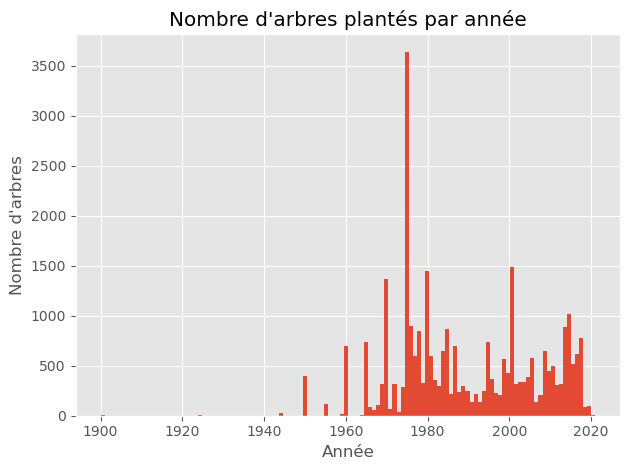

In [9]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, tight_layout=True)

ax.set_title("Nombre d'arbres plantés par année")
ax.set_xlabel("Année")
ax.set_ylabel("Nombre d'arbres")

x = arbresAnnee.keys()
bins = len(arbresAnnee.keys())
counts = arbresAnnee.values()

ax.hist(x, bins, weights=counts);

Triez les tuples (année, genre_botanique) en fonction de l’année de plantation par ordre décroissant.

In [10]:
triAnnee=sorted(anneeGenre, key=lambda x:x[0], reverse=True)
print(triAnnee[-20:])

[(1944, ''), (1944, ''), (1944, 'Prunus'), (1944, 'Prunus'), (1944, 'Alnus'), (1924, 'Diospyros'), (1924, 'Tilia'), (1924, 'Platanus'), (1924, 'Celtis'), (1924, 'Pinus'), (1924, 'Acer'), (1924, 'Acer'), (1924, 'Koelreuteria'), (1924, 'Davidia'), (1924, 'Betula'), (1924, 'Parrotia'), (1900, 'Betula'), (1900, 'Prunus'), (1900, 'Prunus'), (1900, '')]


### Analyse de l'état de la diversité des arbres

Genre botanique
Nombre de genres botaniques présents à Grenoble : 112
Nombre de genres botaniques présents à Grenoble : 112
Information sur :  genre botanique
Nombre : 112
Le plus représenté : Acer
Représentants uniques :
['Acacia', 'Poncinos', 'Sciadopitys', 'Sorbopyrus', 'Castanea', 'Sterculia', 'Laurus', 'Pteroceltis', 'Rhamnus', 'Nyssa', 'Chitalpa']
En ordre décroissant (20 premiers) :
['Acer', 'Platanus', 'Pinus', 'Tilia', 'Fraxinus', 'Carpinus', 'Prunus', 'Populus', 'Betula', 'Alnus', 'Chamaecyparis', 'Quercus', 'Cedrus', 'Pyrus', 'Picea', 'Fagus', 'Liquidambar', 'Magnolia', 'Aesculus', 'Malus']
Total arbres : 16046
Proportions par rapport au total (20 premiers) :  {'Acer': 18.42, 'Platanus': 9.54, 'Pinus': 8.07, 'Tilia': 5.49, 'Fraxinus': 4.93, 'Carpinus': 4.8, 'Prunus': 4.39, 'Populus': 3.5, 'Betula': 2.91, 'Alnus': 2.79, 'Chamaecyparis': 2.19, 'Quercus': 1.91, 'Cedrus': 1.79, 'Pyrus': 1.55, 'Picea': 1.45, 'Fagus': 1.41, 'Liquidambar': 1.39, 'Magnolia': 1.32, 'Aesculus': 1.21, 

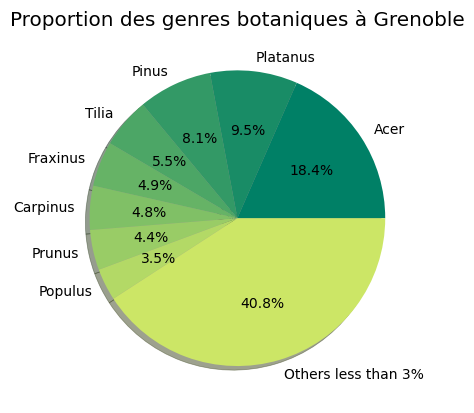

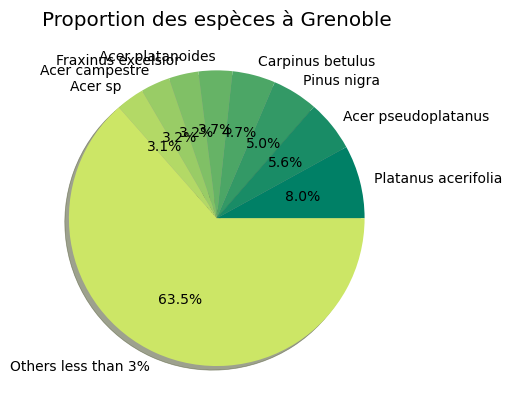

In [76]:
## Genres botaniques ##
print("Genre botanique")
liGenre = takethecol(dataArbresGrenoble,'GENRE_BOTA')
nGenre = len(set([var for var in liGenre if var!='']))
print("Nombre de genres botaniques présents à Grenoble :", nGenre)
genresGrenoble=list(set([var for var in liGenre if var!='']))

cGenre = createCounter(dataArbresGrenoble,'GENRE_BOTA')
print("Nombre de genres botaniques présents à Grenoble :", len(cGenre.keys()))
#print(cGenre)

triGenre,propGenre = infos(cGenre, 'genre botanique')

## camembert ##
colors=colormapArray(propGenre.keys())

fig, ax = plt.subplots()
ax.pie(propGenre.values(), labels=propGenre.keys(), autopct='%1.1f%%', shadow=True, colors=colors);
ax.set_title("Proportion des genres botaniques à Grenoble")

print('\nEspèces')
## Espèces différentes ##

cEsp=createCounter(dataArbresGrenoble,'ESPECE')
print("Nombre d'espèces différentes à Grenoble :", len(cEsp))

triEsp,propEsp=infos(cEsp, 'espece')

## camembert ##
colors=colormapArray(propEsp.keys())

fig, ax = plt.subplots()
ax.pie(propEsp.values(), labels=propEsp.keys(), autopct='%1.1f%%', shadow=True, colors=colors);
ax.set_title("Proportion des espèces à Grenoble");


Les objectifs de la Métro sont respectés en termes de diversité (pas plus de 30% d'un genre et pas plus de 10% d'une espèce).

##### Evolution de la pratique de plantation au cours du temps

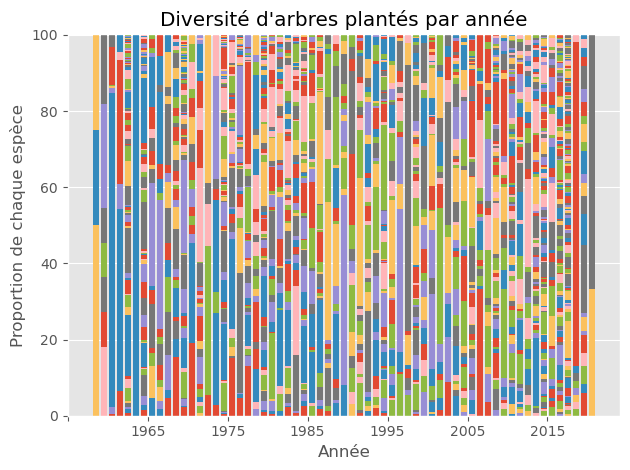

In [161]:
tri=diversiteAnnee(dataArbresGrenoble)

timeSeries = {}
for e in tri['1977'].keys():
    timeSeries[e] = []

for y in tri.keys():
    for e in timeSeries.keys():
        timeSeries[e].append(tri[y][e])
    

fig, ax = plt.subplots(1, 1, tight_layout=True)

ax.set_title("Diversité d'arbres plantés par année")
ax.set_xlabel("Année")
ax.set_ylabel("Proportion de chaque espèce")

years = tri.keys()
nYears = len(tri.keys())

bottom=[0]*len(years)
for e in timeSeries.keys():
    ax.bar(years, timeSeries[e], bottom=bottom, label=years);
    bottom = [x+y for x,y in zip(bottom,timeSeries[e])]

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10));

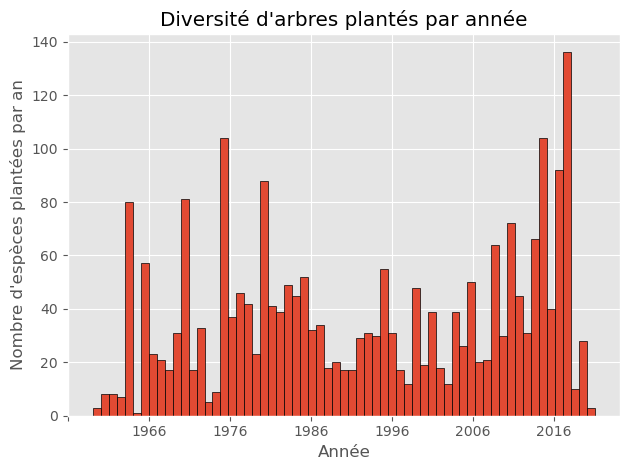

In [167]:
ndiversite={}
for k,var in tri.items():
    n = 0
    for e,ne in tri[k].items():
        if ne>0:
            n += 1
    ndiversite[k] = n

fig, ax = plt.subplots(1, 1, tight_layout=True)

ax.set_title("Diversité d'arbres plantés par année")
ax.set_xlabel("Année")
ax.set_ylabel("Nombre d'espèces plantées par an")

years = ndiversite.keys()
nYears = len(ndiversite.keys())

ax.hist(years, nYears, weights=ndiversite.values(), label=years, ec='k');

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10));

On diversifie plus qu'au cours des 20 dernières années, mais c'est comparable à la diversité dans les années 60-70.

### Analyse et stratégie

In [169]:
genus_prbm = ['Betula', 'Castanea', 'Cupressus', 'Fraxinus','Olea', 'Platanus', 'Aesculus'] #allergènes ou soumis aux maladies
sp_prbm = ['Acer saccharinum', 'Albizzia julibrissin', 'Catalpa bignonioides', 'Ginko biloba',
           'Gleditsia triacanthos', 'Koelreuteria paniculata', 'Laburnum anagyroides', 'Paulownia tomentosa',
           'Prunus pissardi', 'Sophora japonica', 'Acer platanoides', 'Acer pseudoplatanus', 'Betula costata',
           'Betula davurica', 'Betula davurica','Betula jacquemonti','Betula lenta','Betula pendula', 'Betula maximowicziana',
           'Betula pubescens', 'Betula utilis', 'Cryptomeria japonica', 'Cupressus cashmeriana', 'Davidia involucrata',
           'Fagus sylvatica', 'Juglans nigra', 'Juglans ailantifolia', 'Liriodendron tulipifera', 'Magnolia grandiflora',
           'Nerium oleander', 'Picea abies', 'Populus alba', 'Quercus bicolor', 'Quercus macrocarpa','Quercus nigra',
           'Quercus rubra', 'Quercus alba', 'Salix gracolistyla', 'Salix daphnoides', 'Salix cinerea', 'Salix arenaria',
           'Salix alba', 'Salix acutifolia', 'Sorbus aucuparia', 'Platanus acerifolia', 'Acer platanoides',
           'Acer pseudoplatanus'] # supporte mal la secheresse ou le gel ou à eviter dans la metro par soucis de diversification des essences
sp_inv = ['Ailanthus altissima', 'Robinia pseudoacacia', "Acer negundo"] # espèces invasives --> vraiment pas bien !!